<a href="https://colab.research.google.com/github/Kruglikle/EduText-Analyzer/blob/main/ex_types_ml_ru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Очистка txt и преобразование в csv**



Преобразование TST в CSV:

1.   Удаляем мусорные 2–3-буквенные последовательности, неинформативные для анализа.
2.   С помощью регулярных выражений и spaCy оставляем только осмысленные токены и предложения с ≥3 словами.



In [ ]:
def clean_my_text(text):


In [ ]:
import re
import pandas as pd
import spacy

nlp = spacy.blank("ru")

# паттерн для удаления "грязных" последовательностей
# тут мы ищем «слова» из 2-3 букв, состоящие из а-я, которые часто повторяются и явно мусор
garbage_pattern = re.compile(r'\b([а-я]{2,3})\b')

def clean_sentence(text):
    text = text.lower()
    # удаляем мусорные 2-3 буквенные последовательности
    text = garbage_pattern.sub('', text)
    # оставляем только буквы и пробелы
    text = re.sub(r'[^а-яa-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

#деление на чанки, ≥3 слов
def filter_exercises(chunks, min_words=3):
    exercises = []
    for chunk in chunks:
        cleaned = clean_sentence(chunk)
        doc = nlp(cleaned)
        tokens = [t.text for t in doc if t.is_alpha]
        if len(tokens) >= min_words:
            exercises.append(' '.join(tokens))
    return exercises

def preprocess_file_to_csv(file_path, csv_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()

    chunks = [s.strip() for s in re.split(r'[.!?]+', raw_text) if s.strip()]
    exercises = filter_exercises(chunks)

    df = pd.DataFrame({'text': exercises})
    df['label'] = ''

    df.to_csv(csv_path, index=False, encoding='utf-8')
    return df

#input, output
file_path = 'enjoy-2.txt'
csv_path = 'enjoy2-2cleaned.csv'

df = preprocess_file_to_csv(file_path, csv_path)
print(f'Сохранили {len(df)} упражнений в {csv_path}')
print(df.head())


Сохранили 801 упражнений в enjoy2-2cleaned.csv
                                                text label
0  биболетова английский язык enjoy english li st...      
1  a денисенко h h трубанева российский учебник e...      
2  progress check lesson project unit let s read ...      
3                              progress check lesson      
4                                    meet my friends      


Продолжение предобработки: убираем английские слова, так как нас интересуют только установки к упражнениям на рус. языке

Влияние OCR-артефактов минимизируется, и текст готов для корректной автоматической классификации (ура!). После предобработки каждая строка – это упражнение (или часть упражнения).

In [ ]:
import pandas as pd
import re

# Чтение CSV
input_file = '/content/enjoy2-2cleaned.csv'
df = pd.read_csv(input_file)

# Функция проверки наличия английских слов
def has_english(text):
    if pd.isna(text):
        return False
    # Проверяем наличие латинских букв
    return bool(re.search(r'[a-zA-Z]', text))

# Фильтруем строки без английских слов
df_clean = df[~df['text'].apply(has_english)].copy()

# Сохраняем очищенный CSV
output_file = '/content/enjoy2_clean.csv'
df_clean.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"Исходных строк: {len(df)}, после очистки: {len(df_clean)}")


Исходных строк: 801, после очистки: 186


**Обучение модели**

In [ ]:
print(y.value_counts())
print("NaN:", y.isna().sum())


label
яз                    134
ком                    81
языковое               29
коммуникативное         5
-                       3
--                      1
язык                    1
это внутри задания      1
Name: count, dtype: int64
NaN: 51


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Загружаем датасет
df = pd.read_excel("test-train.xlsx")  # столбец text = text, метка = label / перезвать в test-train
X = df["text"]
y = df["label"]

# Стратифицированный split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF векторизация
vectorizer = TfidfVectorizer(ngram_range=(1,2))  # униграммы + биграммы
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Логистическая регрессия
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_tfidf, y_train)

# Предсказания и метрики
y_pred = clf.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8524590163934426

Classification Report:
                  precision    recall  f1-score   support

коммуникативное       0.94      0.68      0.79        25
       языковое       0.81      0.97      0.89        36

       accuracy                           0.85        61
      macro avg       0.88      0.83      0.84        61
   weighted avg       0.87      0.85      0.85        61



**Сохраняем модель на комп + в среду colab**

In [ ]:
import joblib

# Сохраняем TF-IDF векторизатор
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# Сохраняем модель логистической регрессии
joblib.dump(clf, "logreg_model.pkl")

from google.colab import files
files.download("logreg_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Подгружаем модель**

In [ ]:
import pandas as pd
import joblib
import re

# Загружаем модель и TF-IDF
clf = joblib.load("logreg_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Функция препроцессинга (совпадает с обучением)
def merge_split_words(text):
    return re.sub(r'(\w+)-\s+(\w+)', r'\1\2', text)

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

def preprocess_russian(text):
    text = text.lower()
    text = merge_split_words(text)
    text = clean_text(text)
    return text

# Чтение CSV с подготовленным текстом
df = pd.read_csv("test-enjoy-2-standard.csv")  # колонка "exercise"
exercises_clean = df["text"].apply(preprocess_russian)

# Векторизация и предсказание
X_tfidf = vectorizer.transform(exercises_clean)
preds = clf.predict(X_tfidf)

# Сохраняем результат
df["label"] = preds
df.to_csv("pred.csv", index=False, encoding='utf-8-sig')
print("Результат сохранён")


Результат сохранён


**Метрики точности**

1.  Precision (точность) показывает долю правильно классифицированных примеров среди всех предсказанных принадлежащих данному классу.
2.  Recall (полнота) отражает долю правильно классифицированных примеров класса относительно общего числа объектов данного класса.
3.  F1-score — среднее гармоническое точности и полноты, используется для оценки качества модели.
4.  Support обозначает число наблюдений (примеров) каждого класса в тестовом наборе.


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
text = "Tom and Ann are playing in the garden."
doc = nlp(text)
for token in doc:
    print(token.text, token.pos_)


Tom PROPN
and CCONJ
Ann PROPN
are AUX
playing VERB
in ADP
the DET
garden NOUN
. PUNCT


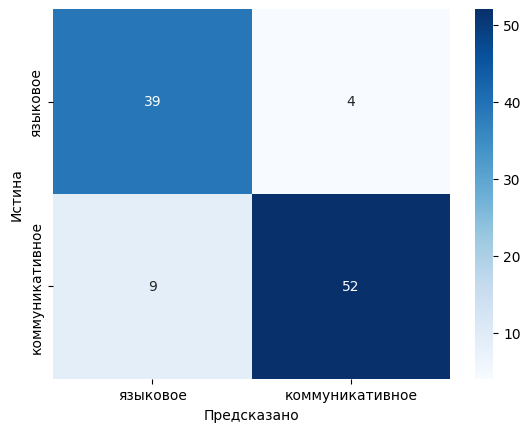

                 precision    recall  f1-score   support

коммуникативное      0.929     0.852     0.889        61
       языковое      0.812     0.907     0.857        43

       accuracy                          0.875       104
      macro avg      0.871     0.880     0.873       104
   weighted avg      0.881     0.875     0.876       104



In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Загружаем файлы
gold = pd.read_csv("gold.csv")   # должно быть: text, label
pred = pd.read_csv("pred.csv")   # должно быть: text, label или label_pred

# убираем лишние пробелы в названиях колонок
gold.columns = gold.columns.str.strip()
pred.columns = pred.columns.str.strip()

# --- Обработка названий колонок ---
# у gold должна быть колонка label → label_true
if "label" in gold.columns:
    gold = gold.rename(columns={"label": "label_true"})

# у pred может быть label или label_pred
if "label" in pred.columns:
    pred = pred.rename(columns={"label": "label_pred"})

# объединяем по text
df = pd.merge(gold, pred, on="text")

# Матрица ошибок
cm = confusion_matrix(df["label_true"], df["label_pred"],
                      labels=["языковое", "коммуникативное"])

# Визуализация
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["языковое", "коммуникативное"],
            yticklabels=["языковое", "коммуникативное"])
plt.xlabel("Предсказано")
plt.ylabel("Истина")
plt.show()

# Отчёт
print(classification_report(df["label_true"], df["label_pred"], digits=3))


In [ ]:
print("Размер gold:", gold.shape)
print("Размер pred:", pred.shape)
print("Размер объединения:", df.shape)
print(df.head(10))
print(df.isna().sum())


Размер gold: (90, 2)
Размер pred: (90, 2)
Размер объединения: (104, 3)
                                                text       label_true  \
0  послушай и найди на картинке артистов, которые...  коммуникативное   
1       послушай и повтори, как знакомятся с артисты         языковое   
2                        разыграйте с одноклассником  коммуникативное   
3              послушай и повтори названия профессий         языковое   
4  назови и сосчитай артистов, которые пришли на ...  коммуникативное   
5                              объяви выход артистов  коммуникативное   
6  догадайся, какие цифры спрятались назови прави...  коммуникативное   
7  послушай и повтори вопросы тома, на которые от...         языковое   
8   скажи, кто ты, как тебя зовут и сколько тебе лет  коммуникативное   
9   скажи, кто ты, как тебя зовут и сколько тебе лет  коммуникативное   

        label_pred  
0         языковое  
1         языковое  
2  коммуникативное  
3         языковое  
4  коммуникативное  

**Confusion matrices** нормализованы, то есть каждая строка суммируется до 1. Значения показывают долю правильных/неправильных предсказаний относительно реального класса (label_gold).

*   Почему unclassified = 0 везде:
В label_gold нет упражнений с меткой unclassified, поэтому строки и столбцы для unclassified заполнены нулями.

Даже если Rule выдаёт unclassified, в нормализованной матрице это будет отображаться в столбце, но строка для unclassified = 0, потому что нет ни одного gold примера с этой меткой.
*   Интерпретация чисел:
Слева: ML vs Gold

0.84 в левом верхнем углу = 84% упражнений, которые в gold коммуникативное, ML правильно классифицировала как коммуникативное.

0.16 = 16% этих упражнений ML ошиблась, присвоив им языковое.

Справа: Rule vs Gold

0.76 = 76% gold коммуникативное классифицировано Rule как коммуникативное.

0.17 = 17% gold коммуникативное Rule отправила в unclassified.

Строк после merge: 86


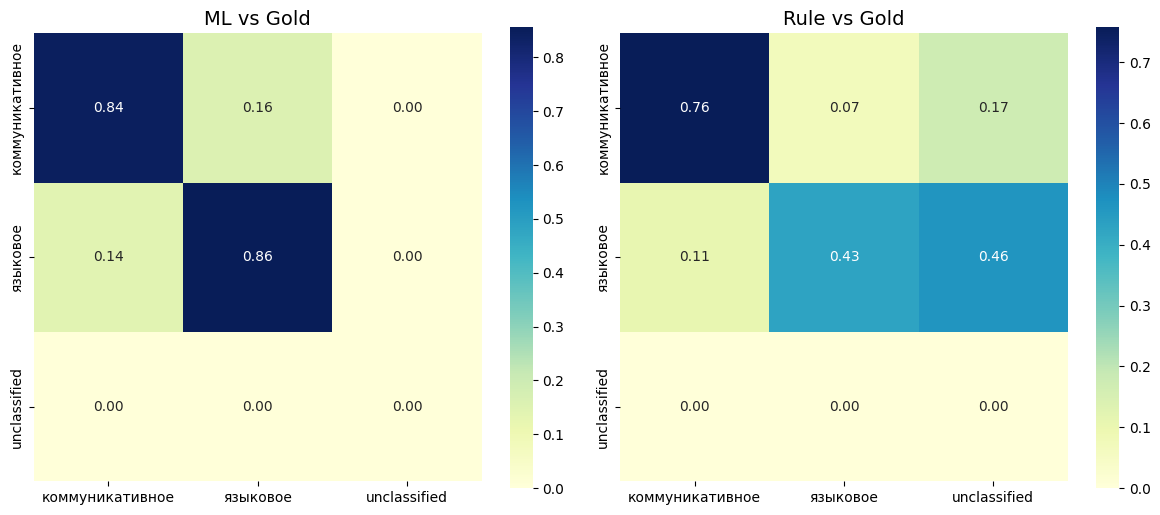

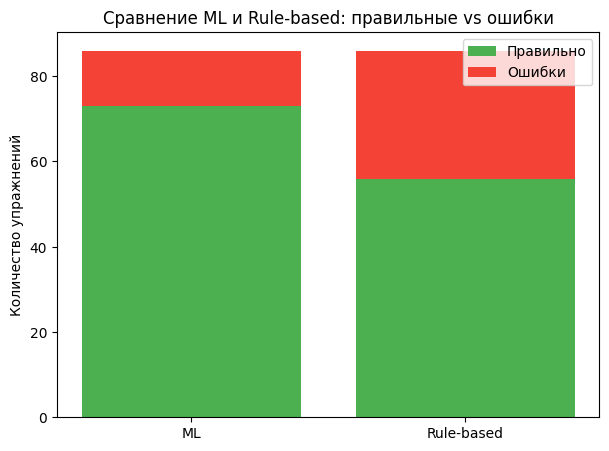

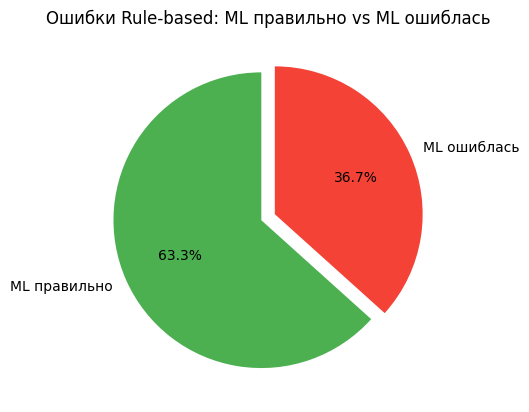

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Загрузка файлов
gold = pd.read_csv("gold.csv")
ml = pd.read_csv("ml.csv")
rule = pd.read_csv("rule.csv")

# Убираем пробелы в колонках
for df_ in [gold, ml, rule]:
    df_.columns = df_.columns.str.strip()

# Переименовываем для удобства
gold = gold.rename(columns={"label": "label_gold"})
ml = ml.rename(columns={"label": "label_ml"})
rule = rule.rename(columns={"label": "label_rule"})

#2. Удаляем дубликаты
gold = gold.drop_duplicates(subset="text")
ml = ml.drop_duplicates(subset="text")
rule = rule.drop_duplicates(subset="text")

#3. Объединяем
df = gold.merge(ml, on="text").merge(rule, on="text")
print("Строк после merge:", len(df))

#4. Нормализация меток
normalize_map = {
    "коммуникативные": "коммуникативное",
    "языковые": "языковое",
    "unclassified": "unclassified"
}
for col in ["label_gold", "label_ml", "label_rule"]:
    df[col] = df[col].replace(normalize_map).fillna("unclassified").astype(str)

classes_all = ["коммуникативное", "языковое", "unclassified"]

#5. Метрики
report_ml = classification_report(df['label_gold'], df['label_ml'],
                                  labels=classes_all, target_names=classes_all, zero_division=0, output_dict=True)
report_rule = classification_report(df['label_gold'], df['label_rule'],
                                    labels=classes_all, target_names=classes_all, zero_division=0, output_dict=True)

# Сохраняем отчёты в CSV
pd.DataFrame(report_ml).transpose().to_csv("classification_report_ml.csv")
pd.DataFrame(report_rule).transpose().to_csv("classification_report_rule.csv")

#6. Confusion Matrix
cm_ml = confusion_matrix(df['label_gold'], df['label_ml'], labels=classes_all, normalize="true")
cm_rule = confusion_matrix(df['label_gold'], df['label_rule'], labels=classes_all, normalize="true")

# visual aid и сохранение
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_ml, annot=True, cmap="YlGnBu", fmt=".2f",
            xticklabels=classes_all, yticklabels=classes_all, ax=axes[0], square=True)
axes[0].set_title("ML vs Gold", fontsize=14)
sns.heatmap(cm_rule, annot=True, cmap="YlGnBu", fmt=".2f",
            xticklabels=classes_all, yticklabels=classes_all, ax=axes[1], square=True)
axes[1].set_title("Rule vs Gold", fontsize=14)
plt.tight_layout()
plt.savefig("confusion_matrices.png")
plt.show()

#7. Правильные/ошибочные
df["ml_correct"] = df["label_gold"] == df["label_ml"]
df["rule_correct"] = (df["label_gold"] == df["label_rule"]) & (df["label_rule"] != "unclassified")

ml_correct = df["ml_correct"].sum()
ml_wrong = len(df) - ml_correct
rule_correct = df["rule_correct"].sum()
rule_wrong = len(df) - rule_correct

# Сохраняем сводку в CSV
summary_df = pd.DataFrame({
    "Method": ["ML", "Rule-based"],
    "Correct": [ml_correct, rule_correct],
    "Wrong": [ml_wrong, rule_wrong],
    "Accuracy (%)": [ml_correct/len(df)*100, rule_correct/len(df)*100]
})
summary_df.to_csv("accuracy_summary.csv", index=False)

# 8. Примеры ошибок
errors_df = df.loc[~df["ml_correct"] | ~df["rule_correct"],
                   ["text", "label_gold", "label_ml", "label_rule", "ml_correct", "rule_correct"]]
errors_df.to_csv("errors_examples.csv", index=False)

#9. Диаграмма ML vs Rule-based
plt.figure(figsize=(7,5))
plt.bar(summary_df["Method"], summary_df["Correct"], label="Правильно", color="#4CAF50")
plt.bar(summary_df["Method"], summary_df["Wrong"], bottom=summary_df["Correct"], label="Ошибки", color="#F44336")
plt.title("Сравнение ML и Rule-based: правильные vs ошибки")
plt.ylabel("Количество упражнений")
plt.legend()
plt.savefig("ml_vs_rule_bar.png")
plt.show()

#10. Ошибки Rule, разбор ML
rule_errors = df[~df["rule_correct"]].copy()
rule_errors["ML_status"] = rule_errors["ml_correct"].map({True: "ML правильно", False: "ML ошиблась"})
rule_errors.to_csv("rule_errors_ml_status.csv", index=False)

# Круговая диаграмма
rule_errors["ML_status"].value_counts().plot.pie(
    autopct='%1.1f%%', colors=["#4CAF50", "#F44336"], startangle=90, explode=(0.05,0.05)
)
plt.title("Ошибки Rule-based: ML правильно vs ML ошиблась")
plt.ylabel("")
plt.savefig("rule_errors_pie.png")
plt.show()


**1.  Количество строк после merge**

86 строк → значит, после удаления дубликатов получилось меньше 90 (некоторые тексты были полностью одинаковы во всех трёх таблицах, убрали повторки с drop_duplicates).

**2.  ML vs Rule-based**
Метод	Правильно	Ошибки	Accuracy
ML	73	13	0.85
Rule	56	30	0.65

ML лучше: точность и recall выше.

Rule-based часто не справляется, особенно там, где gold = языковое → часто выдает unclassified.

**У rule-based 30 ошибок, как повела себя ml модель при решении этих же задач?**

19 она классифицировала правильно, в отличие от rule-based, но на 11 тоже ошиблась.

**Интерпретация таблиц:**

**ML vs Gold (машинное обучение)**
Точность для коммуникативных ошибок: 0.93
Полнота для коммуникативных ошибок: 0.86
F1-Score для коммуникативных ошибок: 0.89
Для языковых ошибок точность составляет 0.91, полнота — 0.96, F1-Score — 0.93.
Общее качество (accuracy) модели составляет 0.92, что довольно хорошо.

**Rule-Based vs Gold (правила)**
У подхода на основе правил присутствует класс "unclassified", однако он не имеет ни одной записи (support = 0).
Точность для коммуникативных ошибок: 0.94
Полнота для коммуникативных ошибок: 0.78
F1-Score для коммуникативных ошибок: 0.85
Языковые ошибки имеют немного лучшую полноту (0.82), точность чуть выше (0.95), и общий F1-Score равен 0.88.
Accuracy всего набора равна 0.81, что заметно ниже результата модели машинного обучения.

**Итоговые выводы:**
Модель машинного обучения показала лучшие результаты практически по всем показателям: общая точность, полнота и средний показатель F1.
Подход на основе правил хуже справляется с задачей классификации, особенно в плане полноты классов ("языковое").
Различия наблюдаются в балансе точности и полноты: ML лучше удерживает баланс, тогда как rule-based жертвует полнотой ради повышения точности.

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report

# === 1. Загрузка русского корпуса ===
df_ru = pd.read_excel("test-train.xlsx")  # колонки: 'text', 'label'
X = df_ru['text']
y = df_ru['label']

# Проверка классов
print("Классы в данных:", y.unique())

# === 2. Разделение на train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 3. TF-IDF ===
tfidf = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,2), min_df=2)

# === 4. Список моделей и гиперпараметров ===
models = {
    "LogReg": (LogisticRegression(max_iter=3000, random_state=42),
               {'clf__C': [0.1, 1, 10]}),
    "SVM": (SVC(random_state=42),
            {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']}),
    "kNN": (KNeighborsClassifier(),
            {'clf__n_neighbors': [3, 5, 7]}),
    "RandomForest": (RandomForestClassifier(random_state=42),
                     {'clf__n_estimators': [100, 200]}),
    "Bagging": (BaggingClassifier(random_state=42),
                {'clf__n_estimators': [50, 100]}),
    "GradBoost": (GradientBoostingClassifier(random_state=42),
                  {'clf__n_estimators': [100, 200], 'clf__learning_rate': [0.05, 0.1]})
}

# === 5. Обучение моделей и сбор результатов ===
results = []
predictions_df = pd.DataFrame()
predictions_df['text'] = X_test
predictions_df['true_label'] = y_test

for name, (clf, params) in models.items():
    print(f"\n🔹 Обучение модели: {name}")
    pipe = Pipeline([('tfidf', tfidf), ('clf', clf)])

    # GridSearchCV
    grid = GridSearchCV(pipe, param_grid=params, scoring='f1_macro', cv=5, n_jobs=-1, verbose=2)
    grid.fit(X_train, y_train)

    # Предсказания на тесте
    y_pred = grid.predict(X_test)

    # Общие метрики
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')

    # Безопасное извлечение F1 по каждому классу
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_per_class = {}
    for cls in y_test.unique():
        if cls in report and 'f1-score' in report[cls]:
            f1_per_class[cls] = report[cls]['f1-score']
        elif cls in report and 'f1' in report[cls]:
            f1_per_class[cls] = report[cls]['f1']
        else:
            f1_per_class[cls] = 0  # если данных нет

    f1_comm = f1_per_class.get('коммуникативное', 0)
    f1_ling = f1_per_class.get('языковое', 0)

    print(f"✅ {name} — лучший F1 (CV): {grid.best_score_:.3f}, Test F1 (macro): {f1_macro:.3f}, Accuracy: {acc:.3f}")

    # Добавляем в результаты
    results.append({
        'Model': name,
        'CV_F1': grid.best_score_,
        'Test_F1_macro': f1_macro,
        'Accuracy': acc,
        'F1_коммуникативное': f1_comm,
        'F1_языковое': f1_ling
    })

    # Сохраняем предсказания для анализа ошибок
    predictions_df[f'{name}_pred'] = y_pred

# === 6. Таблица результатов ===
results_df = pd.DataFrame(results).sort_values("Test_F1_macro", ascending=False)
print("\n📊 Итоговые результаты по русским формулировкам:")
print(results_df)

# === 7. Анализ ошибок (спорные упражнения) ===
model_cols = [col for col in predictions_df.columns if col.endswith('_pred')]
predictions_df['errors_count'] = (predictions_df[model_cols] != predictions_df['true_label'].values[:, None]).sum(axis=1)
predictions_df['models_disagree'] = predictions_df[model_cols].nunique(axis=1) > 1
predictions_df_sorted = predictions_df.sort_values(['errors_count', 'models_disagree'], ascending=[False, False])

# === 8. Сохраняем таблицу предсказаний + анализ ошибок ===
predictions_df_sorted.to_excel("gold_standard_predictions_ru.xlsx", index=False)
print("✅ Таблица предсказаний и спорных упражнений сохранена в 'gold_standard_predictions_ru.xlsx'")

# Опционально: показать топ-20 самых спорных упражнений
print("\n🔹 Топ-20 самых спорных упражнений (русский корпус):")
display(predictions_df_sorted[['text', 'true_label'] + model_cols + ['errors_count', 'models_disagree']].head(20))


Классы в данных: ['коммуникативное' 'языковое']

🔹 Обучение модели: LogReg
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ LogReg — лучший F1 (CV): 0.831, Test F1 (macro): 0.895, Accuracy: 0.902

🔹 Обучение модели: SVM
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ SVM — лучший F1 (CV): 0.843, Test F1 (macro): 0.895, Accuracy: 0.902

🔹 Обучение модели: kNN
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ kNN — лучший F1 (CV): 0.846, Test F1 (macro): 0.818, Accuracy: 0.836

🔹 Обучение модели: RandomForest
Fitting 5 folds for each of 2 candidates, totalling 10 fits
✅ RandomForest — лучший F1 (CV): 0.862, Test F1 (macro): 0.826, Accuracy: 0.836

🔹 Обучение модели: Bagging
Fitting 5 folds for each of 2 candidates, totalling 10 fits
✅ Bagging — лучший F1 (CV): 0.843, Test F1 (macro): 0.844, Accuracy: 0.852

🔹 Обучение модели: GradBoost
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ GradBoost — лучший F1 (CV): 0.819, Test F1 (macro): 0

,text,true_label,LogReg_pred,SVM_pred,kNN_pred,RandomForest_pred,Bagging_pred,GradBoost_pred,errors_count,models_disagree
200,составь вопросы посмотри на картинки и обведи ...,коммуникативное,языковое,языковое,языковое,языковое,языковое,языковое,6,False
81,слушай и повторяй за диктором,коммуникативное,языковое,языковое,языковое,языковое,языковое,языковое,6,False
84,прочитай слова и найди соответствующие им карт...,коммуникативное,языковое,языковое,языковое,языковое,языковое,языковое,6,False
259,прочитай эти слова за диктором кар тинки подск...,коммуникативное,языковое,языковое,языковое,языковое,языковое,языковое,6,False
203,послушай как эти ребята здороваются и гово рят...,языковое,коммуникативное,коммуникативное,коммуникативное,коммуникативное,коммуникативное,языковое,5,True
242,прочитай имена на бейсболках и составь из них ...,коммуникативное,коммуникативное,коммуникативное,коммуникативное,языковое,языковое,языковое,3,True
15,прочитай слова и выбери правильный ответ с,языковое,языковое,языковое,языковое,коммуникативное,коммуникативное,коммуникативное,3,True
300,повтори фразы за диктором одновременно указыва...,коммуникативное,коммуникативное,коммуникативное,языковое,языковое,коммуникативное,языковое,3,True
268,учимся весте послушай песенку прощания и скажи...,коммуникативное,языковое,языковое,языковое,коммуникативное,коммуникативное,коммуникативное,3,True
225,зная столько английских букв ты можешь прочита...,языковое,языковое,языковое,языковое,коммуникативное,коммуникативное,коммуникативное,3,True
